# Resume Parsing

## 1. Load data

In [1]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("data/resume.csv")

In [2]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [3]:
df_resume.shape

(2484, 4)

In [4]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [5]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = 'data/skills.jsonl'

In [6]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [7]:
doc = nlp("Chaky loves ajax.")
doc.ents

(Chaky, ajax)

## 3. Let's try to extract skills from this resume.csv

In [8]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
1754,12488356,SENIOR ENGINEERING PROGRAM MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING
321,27058381,SYSTEM ADMINISTRATOR Expe...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY
1070,12820557,SALES ASSOCIATE Highlight...,"<div class=""fontsize fontface vmargins hmargin...",SALES
1842,25846894,ACCOUNTANT Skills Timb...,"<div class=""fontsize fontface vmargins hmargin...",ACCOUNTANT
2222,17818707,"PROGRAM MANAGER FINANCIAL MANAGER,\nF...","<div class=""fontsize fontface vmargins hmargin...",BANKING


In [9]:
#clean our data
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):
    stopwords    = list(STOP_WORDS)
    doc          = nlp(sentence)
    clean_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SYM' and \
            token.pos_ != 'SPACE':
                clean_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(clean_tokens)

In [10]:
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

"         CONSTRUCTION SAFETY MANAGER         Summary    With 17 years' experience in the field, I have accumulated an extensive working experience, education and team\nbuilding abilities in safety. I will aid in the most effective implementation of procedures to my fullest ability.      Experience   "

In [11]:
preprocessing(random_resume[:300])

"construction safety manager summary with 17 year ' experience field i accumulate extensive working experience education team building ability safety i aid effective implementation procedure full ability experience"

In [12]:
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [13]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
1754,12488356,SENIOR ENGINEERING PROGRAM MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING,senior engineering program manager summary acc...
321,27058381,SYSTEM ADMINISTRATOR Expe...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,system administrator experience 03/2009 compan...
1070,12820557,SALES ASSOCIATE Highlight...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sales associate highlights computer proficienc...
1842,25846894,ACCOUNTANT Skills Timb...,"<div class=""fontsize fontface vmargins hmargin...",ACCOUNTANT,accountant skill timberline mri yardi peachtre...
2222,17818707,"PROGRAM MANAGER FINANCIAL MANAGER,\nF...","<div class=""fontsize fontface vmargins hmargin...",BANKING,program manager financial manager facilities m...


## 4. Let's really extract skills!!

In [14]:
def get_skills(text):
    
    doc = nlp(text)
    
    skills = []
    
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
            
    return unique_skills(skills)

def unique_skills(x):
    return list(set(x))

In [15]:
nlp.get_pipe("ner").labels

('CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART')

In [16]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [17]:
df_resume.Skills.iloc[0]

['release',
 'schedule',
 'data management',
 'finance',
 'engineering',
 'google',
 'interaction',
 'software',
 'design',
 'support',
 'enterprise system',
 'computer science',
 'server',
 'oracle',
 'programming language',
 'business']

## 5. Visualization

Which skills is most important in information management?

In [18]:
# set(df_resume.Category)

In [19]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(44, 6)

In [20]:
all_skills = np.concatenate(df_resume_it.Skills.values)

In [21]:
from collections import Counter, OrderedDict

counting = Counter(all_skills)
counting = OrderedDict(counting.most_common(10))

In [22]:
counting

OrderedDict([('support', 42),
             ('software', 36),
             ('design', 30),
             ('windows', 27),
             ('business', 27),
             ('security', 25),
             ('server', 24),
             ('database', 24),
             ('project management', 19),
             ('documentation', 17)])

<BarContainer object of 10 artists>

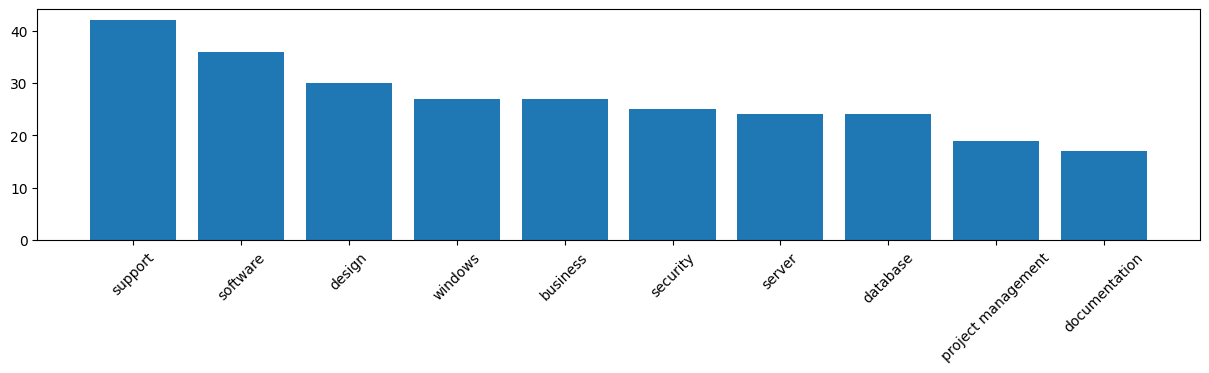

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation=45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [24]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[32]

In [25]:
doc = nlp(text)

In [26]:
# colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
# options = {"colors": colors}

# displacy.render(doc, style='ent', options=options)

## 7. Let's load the PDF - add some realism

In [27]:
from PyPDF2 import PdfReader

reader = PdfReader("data/chaklam_resume.pdf")
page = reader.pages[0]
text = page.extract_text()

In [28]:
text = preprocessing(text)

In [29]:
doc = nlp(text)

In [30]:
doc

chaklam silpasuwanchai email chaklam@ait.asia http://chaklam.com mobile +66 - 63 310 - 9191 http://github.com/chaklam-silpasuwanchai skill •language python java •tool frameworks pytorch springboot •theory machine deep learning natural language processing software engineering hypothesis testing data structures algorithms selected projects •bci speller develop real time speller eeg lock patient •large language models develop conversational ai legal question answering university chatbot summarization etc . large language model •non invasive blood glucose measuring use raman spectroscopy utilize raman spectroscopy non - invasively measure blood glucose fingernail •medical imaging utilize deep learning language model medical image analysis explanation working experience •asian institute technology pathumthani thailand assistant professor school engineering technology january 2019 present •stamford international university bangkok thailand faculty it program faculty business technology march

In [31]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style='ent', options=options)

## 8. Additional Features

### Obtain entities table

Let's obtain an entities table to find important entities such as person names, skills, organizations that exist in the resume.

In [32]:
pd.set_option('display.max_colwidth', None)

In [33]:
# modified from get_skill function
def get_entities(text):
    
    doc = nlp(text)
    
    entities = {
        "PERSON": [],
        "SKILL": [],
        "PRODUCT": [],
        "ORG": []
    }
    
    for ent in doc.ents:
        if ent.label_ in entities:
            entities[ent.label_].append(ent.text)

    for ent_type in entities.keys():
        entities[ent_type] = ', '.join(unique_list(entities[ent_type]))
            
    return pd.DataFrame.from_dict(entities, orient="index", columns=["entities"])

def unique_list(x):
    return list(set(x))

In [34]:
resume_ents = get_entities(text)
resume_ents

,entities
PERSON,"sarcar s. jokinen j. oulasvirta a. wang z. silpasuwanchai c. ren, silpasuwanchai c. ren x. sex, roman w. silpasuwanchai c., pananookooln c. akaranee j. silpasuwanchai c. compare, •large, chaklam silpasuwanchai email, silpasuwanchai c. cheng"
SKILL,"question answering, software engineering, python, testing, natural language processing, framework, algorithms, design, mobile, localization, language model, engineering, interaction, computer science, business, java, pytorch, deep learning, data structures, ai"
PRODUCT,"google, •non"
ORG,"pathumthani thailand, pathumthani thailand bachelor science computer, kochi japan, bangkok thailand faculty, eng, •kasetsart university, •asian institute technology, •kochi university, •medical, •asian institute"


### Find all people names

Finding person entities using the entity rule are not perfect so let's use spaCy's Matcher module to help identify persons in the resume better

In [35]:
from spacy.matcher import Matcher

In [36]:
matcher = Matcher(nlp.vocab)
pattern = [
    {"POS": "PROPN",  # person's name should be a proper noun
     "OP": "{2}",  # person's name usually consists of 2 parts; first name and last name (in some scenario, 3 if a person has middle name)
     "ENT_TYPE": "PERSON"  # person's name is of 'PERSON' entity type
    },
]
matcher.add("PERSON NAME", [pattern], greedy="LONGEST")

In [37]:
matches = matcher(doc)
matches.sort(key = lambda x: x[1])

In [38]:
person_names = []

for match in matches:
    person_names.append((str(doc[match[1]:match[2]]),
                         nlp.vocab.strings[match[0]]))

person_names = list(set(person_names))
person_names

[('jokinen j.', 'PERSON NAME'),
 ('chaklam silpasuwanchai', 'PERSON NAME'),
 ('akaranee j.', 'PERSON NAME'),
 ('roman w.', 'PERSON NAME'),
 ('sarcar s.', 'PERSON NAME'),
 ('pananookooln c.', 'PERSON NAME'),
 ('wang z.', 'PERSON NAME'),
 ('ren x.', 'PERSON NAME'),
 ('silpasuwanchai c.', 'PERSON NAME'),
 ('oulasvirta a.', 'PERSON NAME')]

Let's also add more patterns for detecting URL and email address.

In [39]:
matcher.add("EMAIL", [[{"LIKE_EMAIL": True}]], greedy="LONGEST")
matcher.add("URL", [[{"LIKE_URL": True}]], greedy="LONGEST")

In [40]:
matches = matcher(doc)
matches.sort(key = lambda x: x[1])

In [41]:
entities = []

for match in matches:
    entities.append((str(doc[match[1]:match[2]]),
                         nlp.vocab.strings[match[0]]))

entities = list(set(entities))
entities

[('https://doi.org/10.1145/3359593', 'URL'),
 ('chaklam@ait.asia', 'EMAIL'),
 ('jokinen j.', 'PERSON NAME'),
 ('chaklam silpasuwanchai', 'PERSON NAME'),
 ('akaranee j.', 'PERSON NAME'),
 ('roman w.', 'PERSON NAME'),
 ('http://github.com/chaklam-silpasuwanchai', 'URL'),
 ('pananookooln c.', 'PERSON NAME'),
 ('sarcar s.', 'PERSON NAME'),
 ('http://chaklam.com', 'URL'),
 ('wang z.', 'PERSON NAME'),
 ('ren x.', 'PERSON NAME'),
 ('silpasuwanchai c.', 'PERSON NAME'),
 ('oulasvirta a.', 'PERSON NAME')]

Let's incorporate our matcher into the get_entities function

In [42]:
matcher = Matcher(nlp.vocab)
matcher.add("PERSON", [[{"POS": "PROPN", "OP": "{2}", "ENT_TYPE": "PERSON"}]], greedy="LONGEST")
matcher.add("EMAIL", [[{"LIKE_EMAIL": True}]], greedy="LONGEST")
matcher.add("URL", [[{"LIKE_URL": True}]], greedy="LONGEST")

# modified from get_skill function
def get_entities(text):
    
    entities = {}
    doc = nlp(text)

    # detect and capture patterns using matcher in resume text
    matches = matcher(doc)
    matches.sort(key = lambda x: x[1])

    for match in matches:
        pattern_type = nlp.vocab.strings[match[0]]
        if pattern_type in entities:
            entities[pattern_type].append(str(doc[match[1]:match[2]]))
        else:
            entities[pattern_type] = [str(doc[match[1]:match[2]])]

    # capture entities in resume text
    ent_types = ["SKILL", "PRODUCT", "ORG"]

    for ent in doc.ents:
        ent_type = ent.label_
        if ent_type in ent_types:
            if ent_type in entities:
                entities[ent_type].append(ent.text)
            else:
                entities[ent_type] = [ent.text]


    for ent_type in entities.keys():
        entities[ent_type] = ', '.join(unique_list(entities[ent_type]))
            
    return pd.DataFrame.from_dict(entities, orient="index", columns=["entities"])

def unique_list(x):
    return list(set(x))

In [43]:
resume_ents = get_entities(text)
resume_ents

,entities
PERSON,"chaklam silpasuwanchai, silpasuwanchai c., roman w., jokinen j., pananookooln c., sarcar s., akaranee j., ren x., oulasvirta a., wang z."
EMAIL,chaklam@ait.asia
URL,"https://doi.org/10.1145/3359593, http://chaklam.com, http://github.com/chaklam-silpasuwanchai"
SKILL,"question answering, software engineering, python, testing, natural language processing, framework, algorithms, design, mobile, localization, language model, engineering, interaction, computer science, business, java, pytorch, deep learning, data structures, ai"
PRODUCT,"google, •non"
ORG,"pathumthani thailand, pathumthani thailand bachelor science computer, kochi japan, bangkok thailand faculty, eng, •kasetsart university, •asian institute technology, •kochi university, •medical, •asian institute"
